In [2]:
import numpy as np
import scipy.optimize
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Read in data and plot

In [18]:
# load in the data
data = pd.read_csv("../../data/colony_counting_20200225.csv")
data["ratio"] = data["wildtype / mL"] / data["delta / mL"]
data.head()

,group name,group number,time (hr),time (min),time since start (min),dilution factor,µL plated,number of wildtype colonies,number of delta colonies,wildtype / mL,delta / mL,ratio
0,Suzy,1,10,30,0,10,100,87,106,8700,10600,0.820755
1,Group4,2,10,30,0,10,100,98,110,9800,11000,0.890909
2,Group4,2,11,45,75,10,100,46,42,4600,4200,1.095238
3,Group4,2,12,30,120,10,100,88,107,8800,10700,0.822430
4,Group4,2,13,30,180,10,100,37,21,3700,2100,1.761905


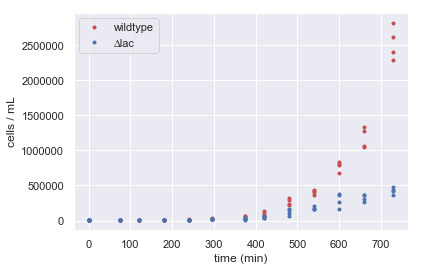

In [27]:
# plot
times = data["time since start (min)"]
N_wildtype = data["wildtype / mL"]
N_delta = data["delta / mL"]

plt.plot(times, N_wildtype, 'r.')
plt.plot(times, N_delta, 'b.')
plt.xlabel("time (min)")
plt.ylabel("cells / mL")
plt.legend(["wildtype", "∆lac"]);

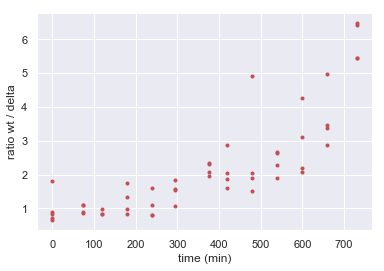

In [28]:
plt.plot(times, data["ratio"], 'r.')
plt.xlabel("time (min)")
plt.ylabel("ratio wt / delta");

As we saw by eye, the wildtype strain takes over. 

In [33]:
def exp_curve(times, A, b):
    
    return A * np.exp(b*times)

In [34]:
popt_ratio, _ = scipy.optimize.curve_fit(exp_curve, 
                                                  data["time since start (min)"], 
                                                  data["ratio"],
                                                  bounds=([0.01, 1/1000], [2, 1/10]))

In [35]:
popt_ratio

array([0.60192408, 0.00293403])

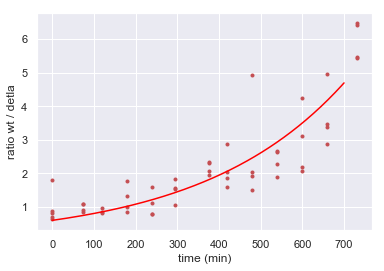

In [36]:
# plot data 
plt.plot(data["time since start (min)"], data["ratio"], 'r.')

time_range = np.linspace(0, 700, 200)

# plot fits
plt.plot(time_range, exp_curve(time_range, *popt_ratio), color="red")
plt.xlabel("time (min)")
plt.ylabel("ratio wt / detla");

## Fit a "bespoke" growth curve

This is a somewhat ad hoc definition of a growth curve, but we define it such that the population is of size $N_0$ until some time threshhold is passed, at which point it begins growing exponentially. 

In [ ]:
def exp_growth(times, N_0, r, t_thresh):
    """ exponential growth with time points t, initial population size N_0, 
    and growth rate r """
    
    N = np.zeros(len(times))
    
    for i, t in enumerate(times):
        
        # lag phase 
        if t < t_thresh:
            N[i] = N_0
            
        # exponetial phase    
        else:
            N[i] = N_0 * np.exp((t-t_thresh)*r)
            
    return N

Let's put some pretty generous bounds on all the parameters and use scipy.optimize as a first pass. 

In [ ]:
# optimize growth curve
# bounds on N_O: 1000 to 100,000
# bound on r: 0.001 to 0.1 (per min)
# bount on t_thresh: 0 to 700
popt_wt, pcov_wt = scipy.optimize.curve_fit(exp_growth, times, N_wildtype, 
                                      bounds=([1000, 0.001, 0], [100000, 0.1, 700]))

popt_delta, pcov_delta = scipy.optimize.curve_fit(exp_growth, times, N_delta, 
                                      bounds=([1000, 0.001, 0], [100000, 0.1, 700]))

In [ ]:
# plot data 
plt.plot(times, N_wildtype, 'r.')
plt.plot(times, N_delta, 'b.')
plt.legend(["wildtype", "∆lac"])

time_range = np.linspace(0, 700, 200)

# plot fits
plt.plot(time_range, exp_growth(time_range, *popt_wt), color="red")
plt.plot(time_range, exp_growth(time_range, *popt_delta), color="blue")
plt.xlabel("time (min)")
plt.ylabel("cells / mL");

In [ ]:
print("wt N_0:", np.round(popt_wt[0]))
print("delta N_0:", np.round(popt_delta[0]))
print()
print("wt lag time (min):", np.round(popt_wt[2]))
print("delta lag time (min):", np.round(popt_delta[2]))
print()
print("wt growth rate (per min):", np.round(popt_wt[1], 5))
print("delta growth rate (per min):", np.round(popt_delta[1], 5))
print()

By eye, this looks pretty good! 

## Let's conisder the data log normally distributed

When we plot on a log scale, we see that the fits are very strongly influenced by the later time points. We would like to have this not be the case, so we should take the log of the data. 

In [ ]:
# plot data 
plt.semilogy(times, N_wildtype, 'r.')
plt.semilogy(times, N_delta, 'b.')
plt.legend(["wildtype", "∆lac"])

time_range = np.linspace(0, 700, 200)

# plot fits
plt.plot(time_range, exp_growth(time_range, *popt_wt), color="red")
plt.plot(time_range, exp_growth(time_range, *popt_delta), color="blue")
plt.xlabel("time (min)")
plt.ylabel("cells / mL");

Let's first plot the log of the data.

In [ ]:
# plot
times = data_trimmed["time since start (min)"]
N_wildtype = data_trimmed["wildtype / mL"]
N_delta = data_trimmed["delta / mL"]

plt.plot(times, np.log(N_wildtype), 'r.')
plt.plot(times, np.log(N_delta), 'b.')
plt.xlabel("time (min)")
plt.ylabel("log cells / mL")
plt.legend(["wildtype", "∆lac"]);

Let's update our exponential growth function for the logarithmic data. 

In [ ]:
def exp_growth_in_log(times, N_0, r, t_thresh):
    """ exponential growth with time points t, initial population size N_0, 
    and growth rate r """
    
    N = np.zeros(len(times))
    
    for i, t in enumerate(times):
        
        # lag phase 
        if t < t_thresh:
            N[i] = N_0
            
        # exponetial phase    
        else:
            N[i] = N_0 + (t-t_thresh)*r
            
    return N

Now let's optimize in log (with our log function and our log data).

In [ ]:
# optimize growth curve
# bounds on N_O: 8 to 11
# bound on r: 0.001 to 0.1 (per min)
# bount on t_thresh: 0 to 700
popt_wt, pcov_wt = scipy.optimize.curve_fit(exp_growth_in_log, times, np.log(N_wildtype), 
                                      bounds=([8, 0.001, 0], [11, 0.1, 700]))

popt_delta, pcov_delta = scipy.optimize.curve_fit(exp_growth_in_log, times, np.log(N_delta), 
                                      bounds=([8, 0.001, 0], [11, 0.1, 700]))

In [ ]:
print("wt N_0:", np.round(popt_wt[0], 1))
print("delta N_0:", np.round(popt_delta[0],1))
print()
print("wt lag time (min):", np.round(popt_wt[2]))
print("delta lag time (min):", np.round(popt_delta[2]))
print()
print("wt growth rate (per min):", np.round(popt_wt[1], 5))
print("delta growth rate (per min):", np.round(popt_delta[1], 5))
print()

In [ ]:
# plot data 
plt.plot(times, np.log(N_wildtype), 'r.')
plt.plot(times, np.log(N_delta), 'b.')
plt.legend(["wildtype", "∆lac"])

time_range = np.linspace(0, 700, 200)

# plot fits
plt.plot(time_range, exp_growth_in_log(time_range, *popt_wt), color="red")
plt.plot(time_range, exp_growth_in_log(time_range, *popt_delta), color="blue")
plt.xlabel("time (min)")
plt.ylabel("log cells / mL");

When accounting for the data being logarithmically distributed, the lag phase for delta is much longer, but the growth rates are the same! 

## Working with ratios rather than counts

In [ ]:
plt.plot(data["time since start (min)"], data["ratio"], '.')
plt.xlabel("time (min)")
plt.ylabel("wt / delta");

Oof. There is not a clear trend here. 

In [ ]:
# mutation arising
wt_mock = 0.0001 * np.exp(np.arange(1000)*0.45)
delta_mock = 0.9999 * np.exp(np.arange(1000)*0.4)

In [ ]:
# 50/50 mix
wt_mock = np.exp(np.arange(100)*0.45)
delta_mock = np.exp(np.arange(100)*0.4)

Ratio of wt to delta scales exponentially. 

In [ ]:
plt.plot(wt_mock / delta_mock, '.')

In [ ]:
plt.plot(wt_mock / (wt_mock + delta_mock), '.')
plt.plot(delta_mock / (wt_mock + delta_mock), '.')